# Importando Bibliotecas Necessárias

In [200]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix,roc_auc_score,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate,cross_val_predict, cross_val_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import eli5
from eli5.sklearn import PermutationImportance

import shap

# Introdução

A ABC é uma empresa de varejo que vende diferentes itens para seus clientes. Para aumentar as suas vendas, ela decidiu conceder crédito para estes clientes com base em um modelo automático de risco. Mais especificamente, dadas diversas informações sobre um cliente X, obtidas no momento da requisição de crédito, ela quer inferir o risco associado a X, ou seja, **a probabilidade de que X não vai pagar a dívida**
que ele contraiu nos meses subsequentes se tornando assim um mau pagador.

O objetivo desse notebook é propor um modelo que faça essa tarefa de classificar os clientes entre bons e maus pagadores.



# Dados

A empresa forneceu dados de clientes solicitantes de crédito no periodo dos meses de agosto e setembro de 2015. Para cada cliente estão disponíveis 15 informações divididas em 4 categorias:


*   demo = Informações Demográficas
*   job1 = Informações sobre emprego
*   income = Informações sobre renda
*   debt = Informações sobre débitos anteriores

Além disso a empresa também informou se esse cliente nos meses seguintes foi um bom pagador ou não. A coluna 'target' indica se aquele cliente é:

* 0 = bom pagador
* 1 = mau pagador





In [147]:
path_csv = 'sample15k_synth.csv'
data = pd.read_csv(path_csv)

features = data.keys()
data.head()

,date,demo1,demo2,demo3,demo4,demo5,demo6,job1,job2,job3,job4,income1,income2,debt1,debt2,debt3,target
0,2015-08-25,18,-1,1,4,12,1,0,0,19,2,0,1034.5000,-1,0,NaN,0
1,2015-08-12,24,1,1,4,60,1,1,0,0,2,0,1344.8500,0,0,0.8218,0
2,2015-08-08,41,1,1,3,98,1,1,0,0,4,0,2275.9000,2,0,0.9558,1
3,2015-08-14,30,0,1,5,108,1,0,0,30,2,0,1344.8500,5,0,0.9304,0
4,2015-08-28,18,-1,1,4,120,1,0,0,0,4,0,1008.6375,-1,0,NaN,0


Para testar o desempenho do modelo proposto separaremos os dados em dois conjuntos. Os dados coletados em agosto de 2015 serão usados para realizar os treinos e os dados coletados em Setembro de 2015 serão utilizados apenas para teste.

In [148]:
train,test = data.query("date < '2015-09-01'") , data.query("date >= '2015-09-01'")

print('{} Samples for train \n{} Samples for test'
          .format(len(train),len(test)))

10000 Samples for train 
5000 Samples for test


A primeira vista podemos observar a ausência de valores na coluna **debt3**. Vamos verificar se há outras colunas que contém campos não preenchidos.

In [149]:
#verifica quantas das celulas de uma coluna estão vazias
data.isnull().sum()

date         0
demo1        0
demo2        0
demo3        0
demo4        0
demo5        0
demo6        0
job1         0
job2         0
job3         0
job4         0
income1      0
income2      0
debt1        0
debt2        0
debt3      454
target       0
dtype: int64

Apenas a coluna **debt3** contém campos não preenchidos, para tratar isso substituiremos essas linhas que não contém valores pela mediana dos valores que já estão preenchidos. 

In [150]:
# mediana dos valores contidos na coluna 'debt3'
median_debt3 = train["debt3"].median()

#Preenchimento de todas as linhas que estão com o campo vazio
train["debt3"].fillna(median_debt3, inplace=True)

#Usaremos a mesma mediana acima para preencher os dados de teste
test["debt3"].fillna(median_debt3, inplace=True)

train.head()

,date,demo1,demo2,demo3,demo4,demo5,demo6,job1,job2,job3,job4,income1,income2,debt1,debt2,debt3,target
0,2015-08-25,18,-1,1,4,12,1,0,0,19,2,0,1034.5000,-1,0,0.8510,0
1,2015-08-12,24,1,1,4,60,1,1,0,0,2,0,1344.8500,0,0,0.8218,0
2,2015-08-08,41,1,1,3,98,1,1,0,0,4,0,2275.9000,2,0,0.9558,1
3,2015-08-14,30,0,1,5,108,1,0,0,30,2,0,1344.8500,5,0,0.9304,0
4,2015-08-28,18,-1,1,4,120,1,0,0,0,4,0,1008.6375,-1,0,0.8510,0


Observando uma descrição geral das features e os histogramas de cada coluna podemos ter uma ideia geral de como estão dispostos os dados de cada coluna. As features abaixo podem ser divididas em variáveis numéricas, categoricas e lógicas(categoricas binárias). No código abaixo separamos as features entre essas categorias: 

In [151]:
cat_var = ['demo2','demo3','demo4', 'demo6','job4','debt1'] #Variaveis Categóricas
num_var = ['demo1', 'demo5','job3', 'income2','debt3'] #Variáveis Numéricas
logi_var = ['job1','job2', 'income1','debt2'] # Variáveis Lógicas

train.describe()

,demo1,demo2,demo3,demo4,demo5,demo6,job1,job2,job3,job4,income1,income2,debt1,debt2,debt3,target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.00000
mean,35.792300,0.333600,1.798700,3.175200,135.657600,1.301600,0.415400,0.04350,46.119400,3.29170,0.087100,2.125062e+03,2.850100,0.107400,0.845548,0.17050
std,13.435885,0.564573,1.284813,1.346137,132.698378,0.742491,0.492816,0.20399,69.928299,1.76718,0.281996,1.047539e+04,1.875842,0.309637,0.077120,0.37609
min,18.000000,-1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.00000,0.000000,7.034600e+02,-1.000000,0.000000,0.142300,0.00000
25%,24.000000,0.000000,1.000000,2.000000,36.000000,1.000000,0.000000,0.00000,0.000000,2.00000,0.000000,1.241400e+03,2.000000,0.000000,0.804175,0.00000
50%,34.000000,0.000000,1.000000,4.000000,101.000000,1.000000,0.000000,0.00000,19.000000,4.00000,0.000000,1.551750e+03,3.000000,0.000000,0.851000,0.00000
75%,45.000000,1.000000,2.000000,4.000000,216.000000,1.000000,1.000000,0.00000,54.000000,4.00000,0.000000,2.255986e+03,4.000000,0.000000,0.901100,0.00000
max,80.000000,1.000000,7.000000,5.000000,2520.000000,5.000000,1.000000,1.00000,722.000000,9.00000,1.000000,1.018982e+06,5.000000,1.000000,0.991700,1.00000


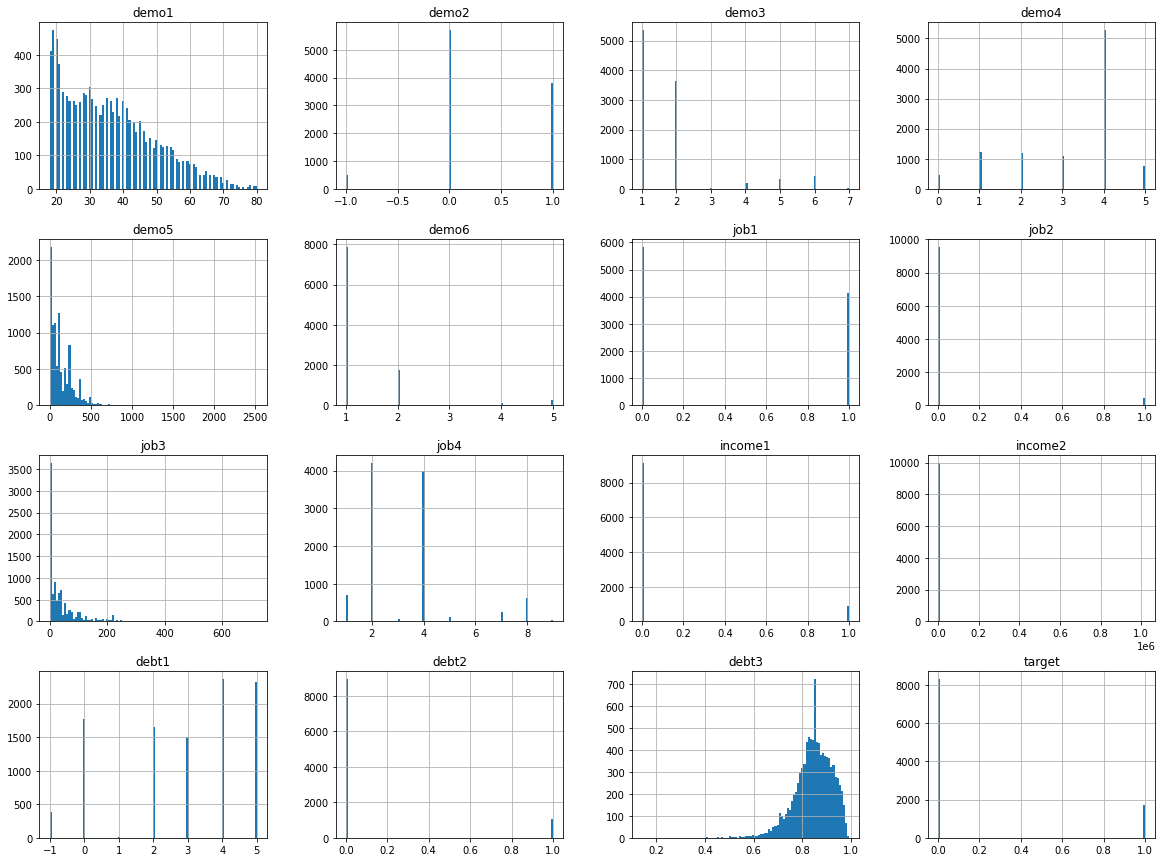

In [152]:
train.hist(bins=100, figsize=(20,15))
plt.show()

Olhando as características das features e os histogramas acima podemos destacar coisas como:

* As colunas **demo1** e **demo2** parecem se tratar respectivamente das seguintes informações: idade e gênero.

* A coluna **income2** possui a gigantesca maioria dos seus dados concentrados entre 0 e 10⁴ e alguns outliers fora desse range.

* Há um grande desbalanceamento entre clientes bons pagadores e clientes mau pagadores, como pode ser visto no histograma **target**. Isso pode ser um problema para o treinamento dos modelos.


In [153]:
train_pos,train_neg = train.query("target == 1 ") , train.query("target == 0")
print("{} Mau Pagadores e {} Bons Pagadores".format(len(train_pos),len(train_neg)))


1705 Mau Pagadores e 8295 Bons Pagadores


In [154]:
#Separando as colunas de caracteristicas do target 
X_train,y_train = train[features[1:16]],train.target
X_test,y_test = test[features[1:16]],test.target

# Avaliação

Para validar os modelos testados nesse notebook, faremos validação cruzada com 5 folds. Por fim testaremos os modelos junto aos dados de teste separados no começo do notebook.

Dado que existe um grande desbalanceamento entre as classes em nosso problema a acurácia não se encaixa tão bem como métrica de avaliação, pois se prevermos todos os clientes como bons pagadores já atingiremos uma alta acurácia uma vez que a maioria dos clientes são bons pagadores. Para avaliar os modelos aqui treinados utilizaremos métricas que avaliem o quão bem são avaliadas as classes em separado, utilizaremos:

* **Revocação**

> 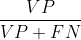


> Pois queremos diminuir o número de falsos negativos, isso é clientes que são maus pagadores mas são classificados como bons pagadores. Esse é um grande problema pois gera prejuizos para a empresa.

* **Especificidade**

> 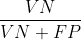

> Precisamos também de uma boa especificidade, uma vez que também queremos manter o número de Falsos positivos baixo. Um modelo que predissesse todos os clientes como mal pagadores teria uma revocação de 100%, entretanto se a empresa dependesse desse modelo nunca daria crédito a nenhum cliente.

* **AUC - Area Under Curve**

> Para balancear as duas métricas anteriores, usaremos a AUC como métrica principal para avaliar os nossos modelos. Está métrica calcula a Area sob a curva ROC, essa curva é um gráfico de diagnóstico para resumir o comportamento de um modelo, calculando as duas métricas acima sob diferentes limites. A curva permite que a gente compare classificadores binários de forma confiável.


Abaixo as funções para validação cruzada e avaliação com as métricas citadas acima.

In [196]:
#Validação Cruzada
def evaluateVal(model,X,y):
  scores = cross_validate(model, X, y,scoring={"roc_auc"}, cv=5)
  print("AUC = {}".format(
            scores['test_roc_auc'].mean()))

# Avaliação de um modelo nos dados X e y    
def evaluate(model,X,y):
  if(model == None):
    y_pred = np.ones(len(y))
  else:  
    y_pred = model.predict(X)
    
  vn, fp, fn, vp = confusion_matrix(y, y_pred).ravel()  
    
  print("Revocação = {}, Especificidade = {}, AUC = {}".format(
      vp/(vp+fn), vn/(vn+fp),roc_auc_score(y,y_pred)))

# Modelos Utilizados

Para tentar construir um modelo que consiga distinguir entre bons e maus pagadores testarei dois dos mais famosos e utilizados modelos de machine learning (aprendizado raso). Ambos são construídos em cima do método de ensemble no nosso caso são modelos contruídos com conjuntos de arvores de decisão.


### Random Forest

Abaixo a função para realizar a GridSearch na Random Forest. Os valores dos parametros selecionados para o grid search foram feitos de forma empirica.

In [177]:
# Grid Search for Random Forest
def gridSearch_RF(X,y,score):
  param_grid = [
          {'bootstrap': [True],
            'max_depth': [4,10,25, 50,100],
            'max_leaf_nodes':[16,32,64,None],
            'max_features': [2,5,7,10,12,15],
            'n_estimators': [1,10,100,200,500]},
          ]

  model= RandomForestClassifier(random_state=0)
  grid_search = GridSearchCV(model, param_grid, cv=5, scoring=score,return_train_score=True)
  grid_search.fit(X, y)
  print(grid_search.best_params_)

### Gradient Boosting

Abaixo a função para realizar a GridSearch no Gradient Boosting. Os valores dos parametros selecionados para o grid search foram feitos de forma empirica. 

In [143]:
# Grid Search

def gridSearch_XB(X,y,score):
  param_grid = {
      "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
      "max_depth":[3,5,7,9,13],
      "subsample":[0.3,0.5, 0.7, 1.0],
      "n_estimators":[10, 50, 100, 200,500]
  }

  model= GradientBoostingClassifier(random_state=0)
  grid_search = GridSearchCV(model, param_grid, cv=5, scoring=score,return_train_score=True)
  grid_search.fit(X, y)
  print(grid_search.best_params_)

### Matriz de confusão

In [255]:
def mtx_c(model,X,y,title,norm):
    disp = plot_confusion_matrix(model, X, y,cmap=plt.cm.Blues,normalize=norm)
    disp.ax_.set_title(title)

# Primeiro Teste

Para verificar o quão bem se saem os modelos com os dados disponibilizados quase inalterados, vamos fazer um gridsearch nos modelos de Random Forest e Gradient Boost para encontrar os melhores parametros de treino e observar suas pontuações nas métricas. 

### Random Forest

In [33]:
# Grid Search para encontrar o melhor parametro para Random Forest com a metrica auc
gridSearch_RF(X_train,y_train,'roc_auc')

{'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'max_leaf_nodes': None, 'n_estimators': 500}


In [211]:
#Modelo com os parametros escolhidos pelo grid search
RF = RandomForestClassifier(max_depth=10,max_features=2,n_estimators=500,max_leaf_nodes=None,random_state=0)

print("\nValidação Cruzada")
evaluateVal(RF,X_train,y_train)

#treino
RF.fit(X_train,y_train)

print("\nTeste no próprio conjunto de treino")
evaluate(RF,X_train,y_train)


Validação Cruzada
AUC = 0.6453108345309244

Teste no próprio conjunto de treino
Revocação = 0.008211143695014663, Especificidade = 1.0, AUC = 0.5041055718475074


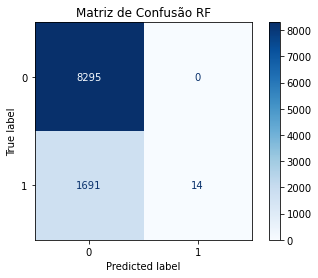

In [256]:
mtx_c(RF,X_train,y_train,'Matriz de Confusão RF',None)
plt.show()

Com os resultados acima, o primeiro modelo parece estar classificando muitos clientes como bons pagadores, assim apresentando muitos Falsos Negativos. Na validação cruzada consegue alcançar um bom AUC mas mesmo nos dados de treino alcança um péssimo resultado.

### Gradient Boosting

In [27]:
# Grid Search para encontrar o melhor parametro para Gradient Boosting com a metrica auc
gridSearch_XB(X_train,y_train,'roc_auc')

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}


In [213]:
#Modelo com os parametros escolhidos pelo grid search
XG = GradientBoostingClassifier(learning_rate=0.01, max_depth=3,n_estimators=500,subsample=0.5,random_state=0)

print("\nValidação Cruzada")
evaluateVal(XG,X_train,y_train)

#treino
XG.fit(X_train,y_train)

print("\nTeste no próprio conjunto de treino")
evaluate(XG,X_train,y_train)


Validação Cruzada
AUC = 0.643935593466014

Teste no próprio conjunto de treino
Revocação = 0.002932551319648094, Especificidade = 1.0, AUC = 0.501466275659824


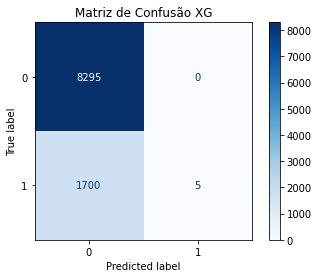

In [257]:
mtx_c(XG,X_train,y_train,'Matriz de Confusão XG',None)
plt.show()

O gradient boosting também não responde bem ao treinamento e obtem resultados parecidos com o RF.

# Tentativas para melhorar desempenho

Com o péssimo resultado nos primeiros teste fora realizado alguns testes para tentar melhorar o desempenho dos modelos.

### Subsampling

Como dito anteriormente, o grande desbalanceamento entre as classes pode causar um grande prejuízo no treino dos modelos. Para tentar diminuir esse prejuízo decidi verificar se temos uma melhora no desempenho dos modelos ao fazer um subsampling dos dados iniciais. O subsampling foi criado pegando todos os 1705 exemplos positivos + 1705 exemplos negativos aleatorios, assim nosso subsampling contém 3410 samples para o treino.

In [221]:
#Pegando um conjunto de 1705 samples dos exemplos negativos
train_neg_sub = train_neg.sample(n=len(train_pos),random_state=0)
print("{} Mau Pagadores e {} Bons Pagadores".format(len(train_pos),len(train_neg_sub)))

#Nosso subsampling
train_sub = pd.concat([train_pos,train_neg_sub])


X_train_sub,y_train_sub = train_sub[features[1:16]],train_sub.target

1705 Mau Pagadores e 1705 Bons Pagadores


In [29]:
# Grid Search para encontrar o melhor parametro para Random Forest com a metrica auc
gridSearch_RF(X_train_sub,y_train_sub,'roc_auc')

{'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'max_leaf_nodes': None, 'n_estimators': 500}


In [222]:
RF_sub = RandomForestClassifier(max_depth=10,max_features=2,n_estimators=500,random_state=0)

print("\nValidação Cruzada")
evaluateVal(RF_sub,X_train_sub,y_train_sub)

#treino
RF_sub.fit(X_train_sub,y_train_sub)

print("\nTeste no próprio conjunto de treino")
evaluate(RF_sub,X_train_sub,y_train_sub)


Validação Cruzada
AUC = 0.6367231103963674

Teste no próprio conjunto de treino
Revocação = 0.9196480938416423, Especificidade = 0.787683284457478, AUC = 0.8536656891495602


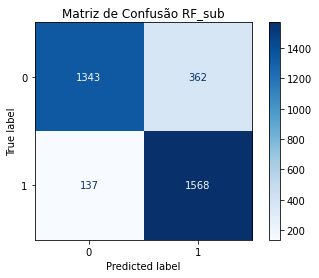

In [258]:
mtx_c(RF_sub,X_train_sub,y_train_sub,'Matriz de Confusão RF_sub',None)
plt.show()

Apesar de estarmos treinando com um conjunto diferente do anterior podemos dizer que esse modelo de Random Forest treinado com o subsampling conseguiu aprender melhor os seus dados de treino. Vamos agora ver se o mesmo acontece com o Gradient Boosting. 

In [30]:
gridSearch_XB(X_train_sub,y_train_sub,'roc_auc')

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.3}


In [225]:
XG_sub = GradientBoostingClassifier(learning_rate=0.01,max_depth=7,n_estimators=200,subsample=0.3,random_state=0)

print("\nValidação Cruzada")
evaluateVal(XG_sub,X_train_sub,y_train_sub)

#treino
XG_sub.fit(X_train_sub,y_train_sub)

print("\nTeste no próprio conjunto de treino")
evaluate(XG_sub,X_train_sub,y_train_sub)


Validação Cruzada
AUC = 0.6326553779207265

Teste no próprio conjunto de treino
Revocação = 0.8533724340175953, Especificidade = 0.7466275659824047, AUC = 0.8


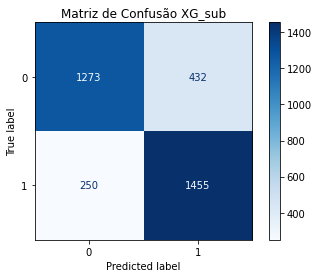

In [259]:
mtx_c(XG_sub,X_train_sub,y_train_sub,'Matriz de Confusão XG_sub',None)
plt.show()

Podemos observar que o mesmo fenômeno ocorre ao treinarmos o Gradient Boosting.

### Oversampling

Motivado pelos resultados alcançados pelo subsampling tentei fazer um oversampling para balancear as classes, dessa vez copiamos exemplos aleatórios dos que são positivos afim de igualar o número de exemplos negativos ou seja: 8295 Mau Pagadores e 8295 Bons Pagadores.

Os testes com Oversampling foram realizados mas não foram postos aqui por não terem um bom resultado. Talvez o número de duplicados entre 1705 e 8295 seja muito grande e fazer esse oversampling não seja uma boa ideia. Por isso abaixo testarei um meio termo. Vamos fazer um teste com 3410 Mau Pagadores e 3410 Bons Pagadores.

In [227]:
train_neg_over = train_neg.sample(n=len(train_pos)*2,random_state=0)
train_pos_over = train_pos.sample(frac=2,replace=True,random_state=0)
print("{} Mau Pagadores e {} Bons Pagadores".format(len(train_pos_over),len(train_neg_over)))

#Nosso subsampling
train_over = pd.concat([train_pos_over,train_neg_over])


X_train_over,y_train_over = train_over[features[1:16]],train_over.target

3410 Mau Pagadores e 3410 Bons Pagadores


In [32]:
# Grid Search para encontrar o melhor parametro para Random Forest com a metrica auc
gridSearch_RF(X_train_over,y_train_over,'roc_auc')

{'bootstrap': True, 'max_depth': 25, 'max_features': 2, 'max_leaf_nodes': None, 'n_estimators': 500}


In [228]:
RF_over = RandomForestClassifier(max_depth=25,max_features=2,n_estimators=500,max_leaf_nodes=None,random_state=0)

print("\nValidação Cruzada")
evaluateVal(RF_over,X_train_sub,y_train_sub)

#treino
RF_over.fit(X_train_over,y_train_over)

print("\nTeste no próprio conjunto de treino")
evaluate(RF_over,X_train_over,y_train_over)


Validação Cruzada
AUC = 0.6311934021895237

Teste no próprio conjunto de treino
Revocação = 1.0, Especificidade = 1.0, AUC = 1.0


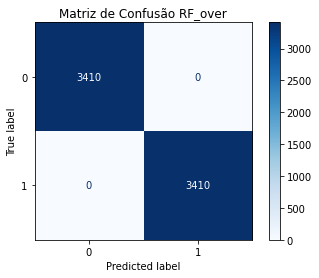

In [260]:
mtx_c(RF_over,X_train_over,y_train_over,'Matriz de Confusão RF_over',None)
plt.show()

Podemos observar de novo uma melhora em comparação ao **RF_sub**, mas essa melhora pode significar algum overfit devido a replicação de vários exemplos. O mesmo efeito acontece abaixo com o Gradient Boosting.

In [40]:
gridSearch_XB(X_train_over,y_train_over,'roc_auc')

{'learning_rate': 0.1, 'max_depth': 13, 'n_estimators': 500, 'subsample': 0.5}


In [230]:
XG_over = GradientBoostingClassifier(learning_rate=0.1,max_depth=13,n_estimators=500,subsample=0.5,random_state=0)

print("\nValidação Cruzada")
evaluateVal(XG_over,X_train_over,y_train_over)

#treino
XG_over.fit(X_train_over,y_train_over)

print("\nTeste no próprio conjunto de treino")
evaluate(XG_over,X_train_over,y_train_over)


Validação Cruzada
AUC = 0.9206185877314436

Teste no próprio conjunto de treino
Revocação = 1.0, Especificidade = 1.0, AUC = 1.0


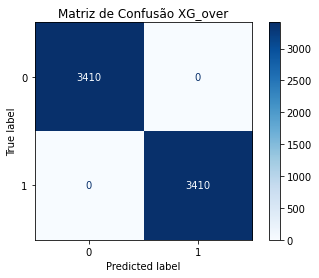

In [261]:
mtx_c(XG_over,X_train_over,y_train_over,'Matriz de Confusão XG_over',None)
plt.show()

### Feature Selection

Afim de verificar se um subconjunto de features consegue desempenho melhor que todas as features juntas vamos realizar uma busca sequencial nos conjuntos de features. Utilizando o modelo **RF_sub** que obteve um bom desempenho anteriormente.

Melhor Conjunto contendo 13 (AUC: 0.641): ('demo1', 'demo2', 'demo3', 'demo4', 'demo5', 'demo6', 'job3', 'job4', 'income1', 'income2', 'debt1', 'debt2', 'debt3')



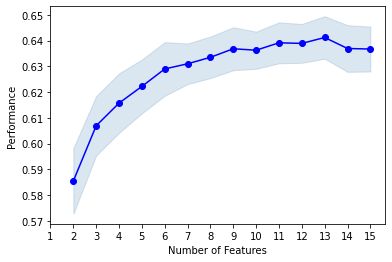

In [233]:
sfs1 = SFS(estimator=RF_sub, k_features=(1, 15),forward=True, floating=False, scoring='roc_auc',cv=5)

sfs1.fit(X_train_sub,y_train_sub)

print('Melhor Conjunto contendo %d (AUC: %.3f): %s\n' % (len(sfs1.k_feature_names_),sfs1.k_score_, sfs1.k_feature_names_))

plot_sfs(sfs1.get_metric_dict(), kind='std_err');

In [235]:
k_features = list(sfs1.k_feature_names_)
RF_sub_feat = RandomForestClassifier(max_depth=10,max_features=2,n_estimators=500,max_leaf_nodes=None,random_state=0)

print("\nValidação Cruzada")
evaluateVal(RF_sub_feat,X_train_sub[k_features],y_train_sub)

#treino
RF_sub_feat.fit(X_train_sub[k_features],y_train_sub)

print("\nTeste no próprio conjunto de treino")
evaluate(RF_sub_feat,X_train_sub[k_features],y_train_sub)


Validação Cruzada
AUC = 0.641213955848333

Teste no próprio conjunto de treino
Revocação = 0.918475073313783, Especificidade = 0.7888563049853372, AUC = 0.85366568914956


Há uma pequena melhora quando fazemos validação cruzada, e não há diferença ao avaliar o modelo no conjunto de treino. Por isso vou utilizar somente as 13 features já que as outras duas não fazem diferença. Abaixo o mesmo teste com o Gradient Boosting.

Melhor Conjunto contendo 14 (AUC: 0.635): ('demo1', 'demo2', 'demo3', 'demo4', 'demo5', 'demo6', 'job2', 'job3', 'job4', 'income1', 'income2', 'debt1', 'debt2', 'debt3')



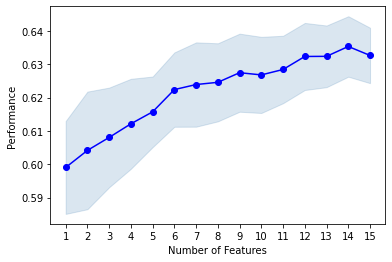

In [241]:
sfs2 = SFS(estimator=XG_sub, k_features=(1, 15),forward=True, floating=False, scoring='roc_auc',cv=5)

sfs2.fit(X_train_sub,y_train_sub)

print('Melhor Conjunto contendo %d (AUC: %.3f): %s\n' % (len(sfs2.k_feature_names_),sfs2.k_score_, sfs2.k_feature_names_))

plot_sfs(sfs2.get_metric_dict(), kind='std_err');

In [242]:
k_features2 = list(sfs2.k_feature_names_)
XG_sub_feat = GradientBoostingClassifier(learning_rate=0.01,max_depth=7,n_estimators=200,subsample=0.3,random_state=0)

print("\nValidação Cruzada")
evaluateVal(XG_sub_feat,X_train_sub[k_features2],y_train_sub)

#treino
XG_sub_feat.fit(X_train_sub[k_features2],y_train_sub)

print("\nTeste no próprio conjunto de treino")
evaluate(XG_sub_feat,X_train_sub[k_features2],y_train_sub)


Validação Cruzada
AUC = 0.6353454132661398

Teste no próprio conjunto de treino
Revocação = 0.852199413489736, Especificidade = 0.7360703812316716, AUC = 0.7941348973607038


# Comparando modelos

Abaixo avaliamos os modelos construídos acima no conjunto de teste:

In [243]:
print("Dummy:")
evaluate(None,X_test,y_test)

print("\nRF:")
evaluate(RF,X_test,y_test)
print("\nXG:")
evaluate(XG,X_test,y_test)
print("\nRF_sub:")
evaluate(RF_sub,X_test,y_test)
print("\nXG_sub:")
evaluate(XG_sub,X_test,y_test)
print("\nRF_over:")
evaluate(RF_over,X_test,y_test)
print("\nXG_over:")
evaluate(XG_over,X_test,y_test)
print("\nRF_sub_feat:")
evaluate(RF_sub_feat,X_test[k_features],y_test)
print("\nXG_sub_feat:")
evaluate(XG_sub_feat,X_test[k_features2],y_test)

Dummy:
Revocação = 1.0, Especificidade = 0.0, AUC = 0.5

RF:
Revocação = 0.0, Especificidade = 1.0, AUC = 0.5

XG:
Revocação = 0.0, Especificidade = 1.0, AUC = 0.5

RF_sub:
Revocação = 0.7368421052631579, Especificidade = 0.5166079516859587, AUC = 0.6267250284745584

XG_sub:
Revocação = 0.7085769980506823, Especificidade = 0.5463009562154001, AUC = 0.6274389771330412

RF_over:
Revocação = 0.24853801169590642, Especificidade = 0.8862606945143432, AUC = 0.5673993531051248

XG_over:
Revocação = 0.24951267056530213, Especificidade = 0.8890286864620031, AUC = 0.5692706785136525

RF_sub_feat:
Revocação = 0.7397660818713451, Especificidade = 0.5181177654755913, AUC = 0.6289419236734681

XG_sub_feat:
Revocação = 0.6968810916179338, Especificidade = 0.5447911424257675, AUC = 0.6208361170218506


Na busca o melhor subconjunto exclui 1 feature, vamos verificar abaixo se essa retirada afeta significativamente o desempenho.

Aparentemente, a exclusão de features parece não fazer sentido. A tentativa de criação de novas features apartir das existentes também foi estudada mas não obteve sucesso.

# Modelo Proposto

Dado os resultados acima escolhemos como modelo final a Random Forest **RF_sub_feat**  que foi treinado com o subsample que iguala o número de clientes bons e maus pagadores e somente com 13 das 15 features iniciais. O modelo selecionado atingiu AUC = 0.628, com uma boa Revocação = 0.739 e uma Especificidade = 0.518. Os primeiros modelos,**RF e XG**, treinados com os todos os samples disponíveis atingiram um resultado ruim, RF e XG ambos tiveram grandes especificidades, isso é, estão prevendo quase todos os clientes como maus clientes já que a Revocação foi 0 para ambos. Os modelos treinados com oversampling **RF_over e XG_over** tem um desempenho melhor do que os primeiros modelos mas são piores que os modelos treinados com o subsampling devido ao fato da replicação de samples acredito que houve um overfit. Talvez a criação de dados sintéticos melhorasse o desempenho dos modelos com oversampling. 

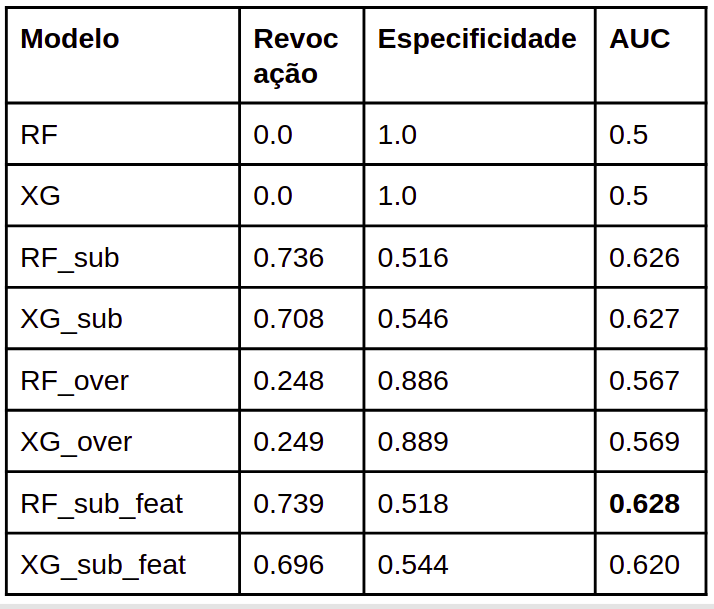


Entende-se que todos os modelos treinados com o subsample alcançaram desempenho muito similares e que provavelmente com um teste estatístico não haveria diferença entre eles. O modelo **RF_sub_feat** fora escolhido simplesmente por atingir o melhor desempenho para o conjunto de teste, além de uma boa revocação que considero mais importante do que a especificidade.

Um dado interessante de ser colocado como feature(se já não está presente) a ser coletado pela empresa é a quantidade de crédito a ser solicitada, assim teriamos uma feature importante na hora de decidir se teremos um bom ou mal pagador. Com esse dado poderiamos estimar se o modelo em questão produz lucro para a empresa.

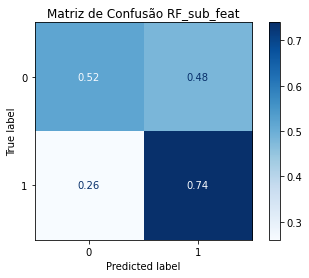

In [262]:
mtx_c(RF_sub_feat,X_test[k_features],y_test,'Matriz de Confusão RF_sub_feat','true')
plt.show()

# Analisando importancia das Features para o modelo

Afim de analisar a importancia das features individualmente para os modelos usarei uma ferramenta chamada SHAP values (Valores de SHAP). Os valores SHAP interpretam o impacto de ter um determinado valor para uma determinada feature em comparação com a previsão que faríamos se esse recurso assumisse algum valor base.

In [265]:
explainer = shap.TreeExplainer(RF_sub_feat)

Com isso podemos ver quão o valor de uma feature foi importante para alguns clientes:

### Cliente 1

In [266]:
row_to_show = 1

data_for_prediction = X_test[k_features].iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

No gráfico acima podemos destacar que a feature debt3 com um valor alto foi a mais importante para que esse cliente fosse considerado um bom pagador.

### Cliente 2

In [267]:
row_to_show = 31

data_for_prediction = X_test[k_features].iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Para esse segundo cliente que foi classificado pelo modelo como um mau pagador também tem uma forte influencia da feature debt3, que dessa vez se apresenta mais baixa.

### Cliente 3

In [268]:
row_to_show = 4230

data_for_prediction = X_test[k_features].iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Este terceiro cliente é um caso bastante interessante, podemos ver que determinadas features acabam empurrando a probabilidade de ele ser um mau pagador para cima enquanto outra boa parte das features faz o caminho contrário.

### Resumo SHAP Values

Acima verificamos os efeitos das features para alguns clientes. Agora vamos tentar observar um resumo do modelo para todos os exemplos de teste. No gráfico abaixo um impacto negativo significa que para aquele valor a feature contribui para que os clientes sejam classificados como bons pagadores.

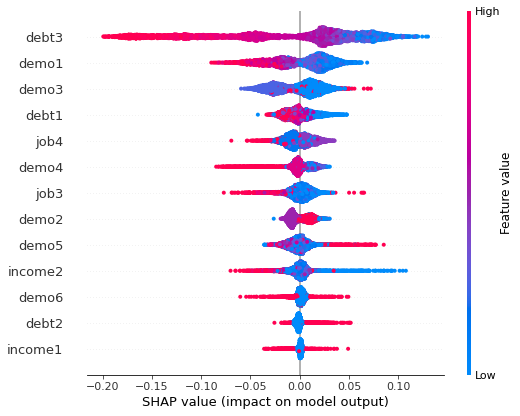

In [270]:
shap_values = explainer.shap_values(X_test[k_features])

shap.summary_plot(shap_values[1], X_test[k_features])

Sobre o gráfico acima:

* **income1,debt2,demo6** - Essas features com valores baixos parecem não contribuir para nem uma da classes. No caso de **income1,debt2** todas elas são variáveis lógicas que quando 0 não contribuem e quando 1 paracem contribuir para ambos os lados não se sabe ao certo o porque. Já para **demo6** o mesmo parece acontecer só que nesse caso temos uma variável categorica que possui a maioria dos seu dados concentrados na categoria 1 e 2, talvez por isso as outras categorias influenciem mais no modelo.


* **debt3,demo1,income2,demo5** - Para o modelo, essas features são as que apresentam maior linearidade, no sentido de valores maiores favorecerem uma das classes enquanto valores menores favorecerem a outra classe. Como podemos ver acima os valores extremos de **debt3** afetam bastante o resultados do modelo. Interessante obeservar que de acordo com o modelo pessoas mais velhas tendem a ser bons pagadores enquanto mais novos tendem a ser maus pagadores (**demo1**).


* **demo2,demo3,debt1,job4** - Essas são features categóricas, em que **demo3** é a feature que mais tem impacto sobre o modelo.As representações dessas features no gráfico acima geralmente não são lineares por se tratar de variaveis categoricas onde suas representações numéricas contidas nos dados geralmente não representam ordem.

